In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import ee, eemont
import geemap
import geemap.colormaps as geecm

import matplotlib.pyplot as plt
import cmocean



In [2]:
#from pyce import gee

# 1. Initialization GEE

In [3]:
ee.Authenticate()
ee.Initialize()

# 2. Load GEE datasets + parameters

In [4]:
dem_glo30 = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [5]:
scale = 30 #Landsat 30m
projection = "EPSG:4326" #GEE le plus stable avec ce SRC

In [6]:
fc_lia = ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/glaciers_1850_final_mars_2025') # demander les références

geom_alpes_FR = ee.FeatureCollection('users/aguerou/ice_and_life/erable_2025/data_ancillary/alpes_francaises')

geom_RGI_2000=ee.FeatureCollection('projects/sat-io/open-datasets/RGI/RGI_VECTOR_MERGED_V7')
geom_RGI_2015=ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/c3s_gi_rgi11_s2_2015_v2')

In [7]:
#Image landsat processed pour comparer
# Landsat_processed_2015=ee.Image('projects/ee-roniritzganem/assets/stage_carrtel_2025/Landsat_Alpes_processed/Landsat_Alpes_processed_2015')
# Landsat_processed_2000=ee.Image('projects/ee-roniritzganem/assets/stage_carrtel_2025/Landsat_Alpes_processed/Landsat_Alpes_processed_2000')
# Landsat_processed_2000

In [8]:
years = range(1984, 2025)
# Créer une liste d'images en important les fichiers du répertoire
Landsat_annualCollection_index= ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/landsat_annual_median_index/Landsat_{year}")
    for year in years
])

In [9]:
geom_RGI_FR_2000=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2000')
geom_RGI_FR_2015=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2015')
geom_lia = ee.Geometry.convexHull(fc_lia.geometry())

In [10]:
geom_RGI_FR_2000_propre=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_Strict_2000')
geom_RGI_FR_2015_propre=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_Strict_2015')

In [11]:
# Map=geemap.Map(center=[45.9, 6.8], zoom=7)

# Map.setCenter(6.5, 45.5, 8)

# # Map.addLayer(fc_lia, {}, 'LIA')
# Map.addLayer(geom_alpes_FR, {}, 'alpes_Fr')

# Map.add_basemap('SATELLITE')
# Map.layers[-1].opacity = 0.5

# Map.addLayer(geom_RGI_FR_2000_propre, {}, 'RGI 2000 FR')
# Map.addLayer(geom_RGI_FR_2015_propre, {}, 'RGI 2015 FR')

# Map.addLayer(geom_RGI_2000, {}, 'RGI 2000 ')
# Map.addLayer(geom_RGI_2015, {}, 'RGI 2015 ')

# Map

Seuils de référence

In [12]:
SlopeThresh = 20 
AltitudeThresh = 1000

#Cloud correction
cloudThresh = 0.4
cloudBuff = 1000
cloudCover = 50

In [13]:
WaterThresh = 0.2
TempThresh = -1

In [14]:
VegetationThresh = 0.2

In [15]:
#Seuils Test
# 1,8 https://doi.org/10.1016/j.rse.2021.112862
GlacierThreshold_1 = 2
GlacierThreshold_2 = 3
GlacierThreshold_3 = 4
GlacierThreshold_4 = 6


In [16]:
palette_diff = geecm.get_palette('RdBu', n_class=7)
palette_ndwi = geecm.get_palette('viridis', n_class=7)
palette_gbr = cmocean.cm.ice
palette_dem = cmocean.cm.solar
palette_slope = cmocean.cm.matter
visParams_diff = {'min': -2, 'max': 2, 'palette': palette_diff}
visParams_ndwi = {'min': 0.0, 'max': 0.5, 'palette': palette_ndwi}
visParams_gbr = {'min': 0, 'max': 10, 'palette': palette_gbr}
visParams_dem = {'min': 1000, 'max': 4000, 'palette': palette_dem}
visParams_slope = {'min': 20, 'max': 60, 'palette': palette_slope}

vis_params_landsat = {
    'bands': ['RED', 'GREEN', 'BLUE'],  # RGB
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.3
}

# 3 palettes glacier avec nuances différentes (au choix ici pour exemple)
visGLACIER_1 = {"min": 0, "max": 1, "palette": ["#808080", "#228B22"]}   # Vert forêt
visGLACIER_2 = {"min": 0, "max": 1, "palette": ["#808080", "#FF00FF"]}   # Magenta
visGLACIER_3 = {"min": 0, "max": 1, "palette": ["#808080", "#00FFFF"]}   # Cyan
visGLACIER_4 = {"min": 0, "max": 1, "palette": ["#808080", "#FF0000"]}   # Rouge vif
visWATER = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}  # Cyan → Bleu → Bleu foncé
# visWATER_2 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}
# visWATER_3 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}

visVEGET = {"min": 0, "max": 1, "palette": ["#808080", "#33a02c"]}

# 3. FUNCTIONS

In [17]:

def classifyGlacier(image, seuil):
    temp = image.select('GBR').gt(seuil)
    mask = temp.where(temp.gte(1), 1)
    return image.addBands(mask.rename('GLACIER').toInt())

def classifyWater(image):
    temp = image.select('NDWI').gt(WaterThresh)
    temp2 = temp.where(temp.gte(1), 2)
    mask = temp2.updateMask(slope_mask).unmask(0)
    return image.addBands(mask.rename('WATER').toInt())

def classifyVegetation(image):
    temp = image.select('NDVI').gt(VegetationThresh)
    mask = temp.where(temp.gte(1), 3)
    return image.addBands(mask.rename('VEGETATION').toInt())


In [18]:
def apply_classify_conditions(image):
    return image.select('WATER') \
                .where(image.select('GLACIER') == 1, 1) \
                .where(image.select('VEGETATION') == 3, 3) \
                .addBands(image.select(['GLACIER', 'VEGETATION', 'year'])) \
                .copyProperties(image, image.propertyNames())



In [19]:
def get_slope(image):
    return ee.Terrain.slope(image)

In [20]:
def removeValley(image):
    return image.updateMask(valley_mask)

In [21]:
def mask_clip_lia(image): #chaque image median a ete clip to lia
    return image.updateMask(image.neq(0))


In [22]:
def clip_to_geometry(image,geom):
    return image.clip(geom)

Pour la comparaison Landsat

In [23]:
def addCloud(image):
    # Sélectionner le bande TIR et appliquer une échelle d'unité (unitScale)
    TIR = image.select('TIR').unitScale(240, 270).rename('sTIR')
    
    # Sélectionner le bande SWIR2
    SWIR2 = image.select('SWIR2').rename('sSWIR2')
    
    # Ajouter les bandes sTIR et sSWIR2
    temp = TIR.addBands(SWIR2)
    
    # Ajouter la bande de différence normalisée NDCI
    temp2 = temp.addBands(temp.normalizedDifference(['sTIR', 'sSWIR2']).rename('NDCI'))
    
    # Ajouter une bande NDCIt qui est le seuil des nuages
    temp3 = temp2.addBands(temp2.select('NDCI').lte(cloudThresh).rename('NDCIt'))
    
    # Calculer le masque avec la transformation de distance
    mask = temp3.select('NDCIt') \
                .fastDistanceTransform(50, 'pixels', 'squared_euclidean') \
                .sqrt() \
                .multiply(ee.Image.pixelArea().sqrt()) \
                .gt(cloudBuff)
    
    # Appliquer le masque à l'image 
    return image.updateMask(mask)

In [24]:
#  Fonction de prétraitement des images (mise à l'échelle et ajout du masque des nuages)
def preprocess(img):
    img = addCloud(img)  # Appliquer le masque des nuages
    optical = img.select(['BLUE', 'GREEN', 'RED']) \
        .multiply(0.0000275).add(-0.2) \
        .clamp(0, 1)  # Mise à l'échelle pour obtenir la réflectance
    return optical.copyProperties(img, img.propertyNames())


Evaluation des Seuils

In [25]:
# def generate_seuil_for_years(year_selected,Threshold):
#    # Sélection de l'image annuelle
#     image_annee = (Landsat_annualCollection_index
#                    .filter(ee.Filter.eq('year', year_selected))
#                    .first())
    
#     image_finale = ee.ImageCollection(image_annee)
    
#     # Traitement pour chaque seuil
#     Seuil = image_finale.map(classifyWater)\
#                          .map(lambda image: classifyGlacier(image, Threshold))\
#                          .map(classifyVegetation)\
#                          .map(lambda img: img.selfMask())
    
#     # Sélection des bandes utiles
#     Seuil_selected = Seuil.select(['GLACIER', 'WATER', 'VEGETATION'])

#      # Conversion en image unique par seuil (mosaic)
#     aire_threshold = Seuil_selected.mosaic()
    
#     return aire_threshold

In [26]:
def generate_seuil_for_years(year_selected,Threshold):
   # Sélection de l'image annuelle
    image_annee = (Landsat_annualCollection_index
                   .filter(ee.Filter.eq('year', year_selected))
                   .first())
    
    image_finale = ee.ImageCollection(image_annee)
    
    # Traitement pour chaque seuil
    Seuil = image_finale.map(lambda image: classifyGlacier(image, Threshold))\
                         .map(lambda img: img.selfMask())
    
    # Sélection des bandes utiles
    Seuil_selected = Seuil.select(['GLACIER'])

     # Conversion en image unique par seuil (mosaic)
    aire_threshold = Seuil_selected.mosaic()
    
    return aire_threshold

In [27]:
def evaluer_seuils_glaciers(year_selected, rgi_geom, aire_threshold):
    # Calcul de la surface pour chaque feature du RGI
    rgi_with_area = rgi_geom.map(
        lambda feature: feature.set(
            {'areakm²': feature.geometry().area().divide(1e6)}))  # m² -> km²

    # Surface totale du RGI
    surface_totale_rgi = rgi_with_area.aggregate_sum('areakm²')

    # Images des seuils pour l'année sélectionnée (supposées préchargées)

    # Surface dans le RGI
    glacier_in_rgi = aire_threshold.clip(rgi_geom).select('GLACIER') \
        .multiply(ee.Image.pixelArea()) \
        .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface totale (dans toute la zone d’étude)
    glacier_total = aire_threshold.select('GLACIER') \
            .multiply(ee.Image.pixelArea()) \
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface hors RGI, normalisée
    commission_error = (1-(glacier_in_rgi.divide(glacier_total)))*100 # le mieux est le plus proche de 0

        # Accuracy (recouvrement avec le RGI)
    completude = glacier_in_rgi.divide(surface_totale_rgi).multiply(100)

    # Retourne les résultats sous forme de dictionnaires
    return commission_error, completude

In [28]:
def afficher_carte_seuils(year_selected):

    Map = geemap.Map(center=[45.9, 6.8], zoom=7)
    Map.setCenter(6.5, 45.5, 8)

    Map.addLayer(fc_lia, {}, 'LIA')
    Map.add_basemap('SATELLITE')
    Map.layers[-1].opacity = 0.5

    #Map.addLayer(Landsat_processed_2000, vis_params_landsat, f'Landsat {year_selected} - Moyenne août {year_selected}')

    Map.addLayer(geom_RGI_FR_2000.style(color='blue', width=1), {}, 'RGI 2000 FR')
    Map.addLayer(geom_RGI_FR_2015.style(color='white', width=1),{}, 'RGI 2015 FR')


    
    for i in range(1, 5):
        threshold_value = globals()[f"GlacierThreshold_{i}"]  
        seuil_image = generate_seuil_for_years(year_selected, threshold_value)
        vis = globals()[f"visGLACIER_{i}"]
    
        vector = seuil_image.select('GLACIER').reduceToVectors(
            geometryType='polygon',
            reducer=ee.Reducer.countEvery(),
            scale=30,
            geometry=geom_lia,
            labelProperty='zone',
            maxPixels=1e13
            ).style(**{
            'color': vis['palette'][1],
            'fillColor': '00000000',
            'width': 1
             })

        #Map.addLayer(vector, {}, f'Glacier_Seuil_{i} - Contours')
        Map.addLayer(seuil_image.select('GLACIER'), vis, f'Glacier_Seuil{i}')

    Map.addLayer(geom_RGI_FR_2000.style(color='blue', width=1), {}, 'RGI 2000 FR_bis')
    Map.addLayer(geom_RGI_FR_2015.style(color='white', width=1),{}, 'RGI 2015 FR_bis')
    
    return Map

# II. Terrain data / Timeseries Landsat

Terrain

In [29]:
dem = ee.ImageCollection(dem_glo30).filterBounds(fc_lia).select("DEM")
dem_mosaic = dem.mosaic().clip(fc_lia)
slope = dem.map(get_slope).mosaic().clip(fc_lia) \
#need to map on single image for slope function to work fine

slope_mask = slope.lt(SlopeThresh)
valley_mask = dem_mosaic.gt(AltitudeThresh)

# 4. Choix Seuil GBR

idée de choix de classif


Création de 4 classification distincte en fonction de GlacierTreshold

In [30]:
Seuil1_2000=generate_seuil_for_years(2000,GlacierThreshold_1)
Seuil2_2000=generate_seuil_for_years(2000,GlacierThreshold_2)
Seuil3_2000=generate_seuil_for_years(2000,GlacierThreshold_3)
Seuil4_2000=generate_seuil_for_years(2000,GlacierThreshold_4)


In [31]:
Seuil1_2015=generate_seuil_for_years(2015,GlacierThreshold_1)
Seuil2_2015=generate_seuil_for_years(2015,GlacierThreshold_2)
Seuil3_2015=generate_seuil_for_years(2015,GlacierThreshold_3)
Seuil4_2015=generate_seuil_for_years(2015,GlacierThreshold_4)


# Visualisation GBR

# Evaluation des seuils

In [33]:
commission_error_2015, completude_2015 = evaluer_seuils_glaciers("2015", geom_RGI_FR_2015, Seuil1_2015 )


In [35]:
"commission (%):", commission_error_2015.getInfo()

('commission (%):', 12.227856669312798)

In [36]:
"completude (%):", completude_2015.getInfo()

('completude (%):', 82.49209980585684)

In [37]:
# Liste des seuils avec leur valeur de seuil utilisée
years_studied=[2000,2015]

seuils_2015 = [
    (GlacierThreshold_1, Seuil1_2015),
    (GlacierThreshold_2, Seuil2_2015),
    (GlacierThreshold_3, Seuil3_2015),
    (GlacierThreshold_4, Seuil4_2015)
]

seuils_2000 = [
    (GlacierThreshold_1, Seuil1_2000),
    (GlacierThreshold_2, Seuil2_2000),
    (GlacierThreshold_3, Seuil3_2000),
    (GlacierThreshold_4, Seuil4_2000)
]

# Initialisation des résultats
resultats = []

# Boucle pour 2015
for seuil_valeur, seuil_objet in seuils_2015:
    commission_error, completude = evaluer_seuils_glaciers("2015", geom_RGI_FR_2015, seuil_objet)
    resultats.append({
        "Année": 2015,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })

# Boucle pour 2000
for seuil_valeur, seuil_objet in seuils_2000:
    commission_error, completude = evaluer_seuils_glaciers("2000", geom_RGI_FR_2000, seuil_objet)
    resultats.append({
        "Année": 2000,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })


# Création du DataFrame à partir des résultats existants
df_flat = pd.DataFrame(resultats)

# Pivot pour avoir une structure à colonnes multiples
df_pivot = df_flat.pivot(index="Seuil (valeur)", columns="Année", values=["Commission (%)", "Complétude (%)"])

# Réorganiser pour que l'année soit au premier niveau
df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1, level=0)

# Calcul manuel des moyennes par seuil sur les deux années
df_moyennes = df_pivot.groupby(level=1, axis=1).mean()

# Ajouter les colonnes 'Moyenne' dans le multi-index
df_pivot[("Moyenne", "Commission (%)")] = df_moyennes["Commission (%)"]
df_pivot[("Moyenne", "Complétude (%)")] = df_moyennes["Complétude (%)"]

# Réordonner les colonnes pour avoir "Moyenne" à la fin
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Affichage
print("                Évaluation des seuils pour les années 2000 et 2015")
print(df_pivot)

                Évaluation des seuils pour les années 2000 et 2015
Année                    2000                          2015                 \
               Commission (%) Complétude (%) Commission (%) Complétude (%)   
Seuil (valeur)                                                               
2                   21.610372      84.506628      12.227857      82.492100   
3                   14.914052      80.658883       7.472952      78.115069   
4                   11.384031      77.719197       5.348089      74.709213   
6                    7.424047      72.856465       3.144183      69.231262   

Année                 Moyenne                 
               Commission (%) Complétude (%)  
Seuil (valeur)                                
2                   16.919114      83.499364  
3                   11.193502      79.386976  
4                    8.366060      76.214205  
6                    5.284115      71.043863  


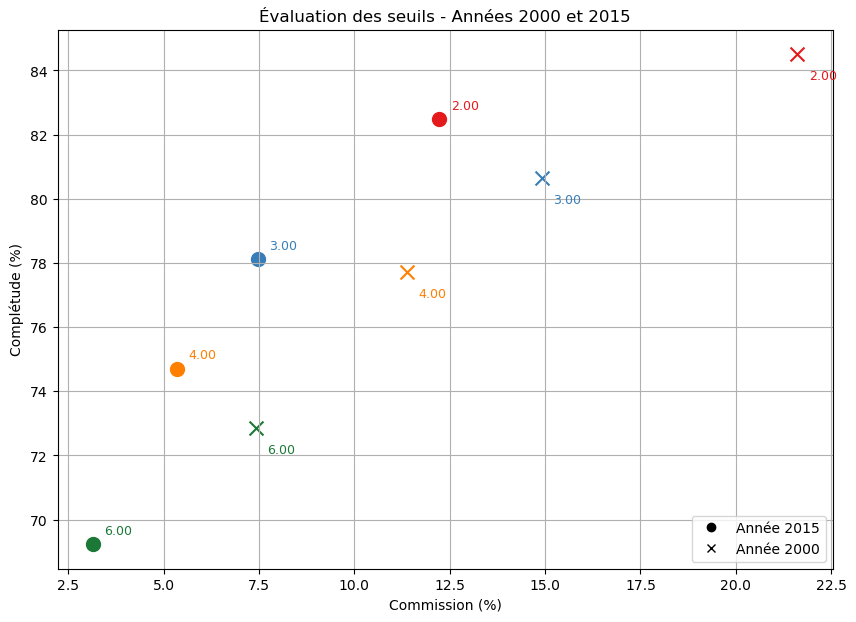

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Séparer les résultats par année
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}

# Création de la figure
plt.figure(figsize=(10, 7))

# Points 2015 (ronds)
for idx, row in df_2015.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='o', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y + 0.3), fontsize=9, color=color)

# Points 2000 (croix)
for idx, row in df_2000.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='x', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y - 0.8), fontsize=9, color=color)

# Axes et titre
plt.ylabel("Complétude (%)")
plt.xlabel("Commission (%)")
plt.title("Évaluation des seuils - Années 2000 et 2015")
plt.grid(True)
# plt.gca().invert_xaxis()

# Légende 
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Année 2015', linestyle='None'),
    Line2D([0], [0], marker='x', color='black', label='Année 2000', linestyle='None')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

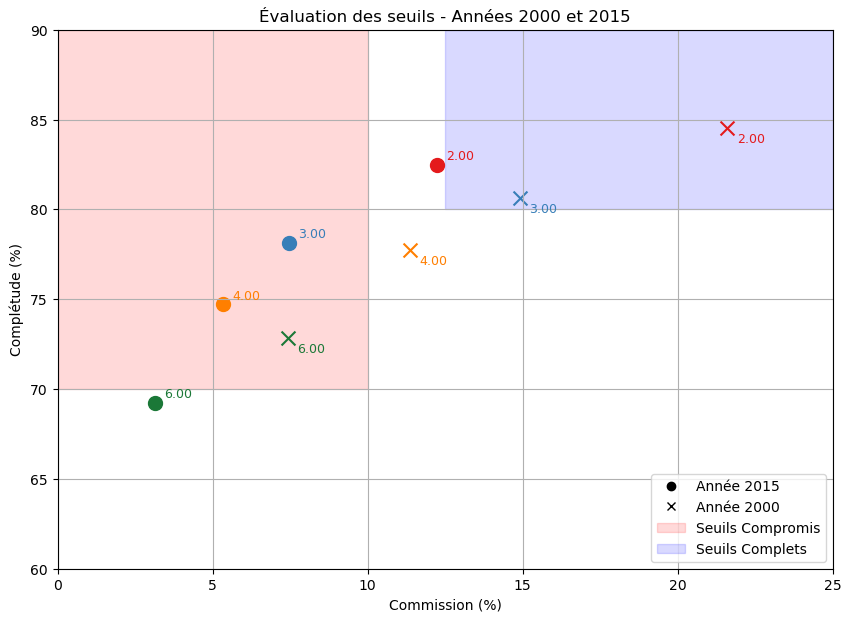

In [39]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Séparer les résultats par année
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

# Couleurs des seuils (par index)
couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}

# Création de la figure
plt.figure(figsize=(10, 7))

# Zone "Seuils Compromis" (rectangle rouge semi-transparent)
plt.gca().add_patch(plt.Rectangle((0, 70), 10, 20, color='red', alpha=0.15, label='Seuils Compromis'))

# Zone "Seuils Complets" (rectangle bleu semi-transparent)
plt.gca().add_patch(plt.Rectangle((12.5, 80), 12.5, 10, color='blue', alpha=0.15, label='Seuils Complets'))

# Points 2015 (ronds)
for idx, row in df_2015.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='o', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y + 0.3), fontsize=9, color=color)

# Points 2000 (croix)
for idx, row in df_2000.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='x', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y - 0.8), fontsize=9, color=color)

# Axes et titre
plt.ylabel("Complétude (%)")
plt.xlabel("Commission (%)")
plt.title("Évaluation des seuils - Années 2000 et 2015")
plt.grid(True)
plt.xlim(0,25)
plt.ylim(60,90)

# Légende 
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Année 2015', linestyle='None'),
    Line2D([0], [0], marker='x', color='black', label='Année 2000', linestyle='None'),
    Patch(facecolor='red', edgecolor='red', alpha=0.15, label='Seuils Compromis'),
    Patch(facecolor='blue', edgecolor='blue', alpha=0.15, label='Seuils Complets')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()



---------------------------------------------

In [40]:
def generate_seuil_for_years_smoothed(year_selected,Threshold):
   # Sélection de l'image annuelle
    image_annee = (Landsat_annualCollection_index
                   .filter(ee.Filter.eq('year', year_selected))
                   .first())
    
    image_finale = ee.ImageCollection(image_annee)
    
    # Traitement pour chaque seuil
    Seuil = image_finale.map(classifyWater)\
                         .map(lambda image: classifyGlacier(image, Threshold))\
                         .map(classifyVegetation)\
                         .map(lambda img: img.selfMask())
    
    # Sélection des bandes utiles
    Seuil_selected = Seuil.select(['GLACIER', 'WATER', 'VEGETATION'])

     # Conversion en image unique par seuil (mosaic)
    aire_threshold = Seuil_selected.mosaic()
    
    return aire_threshold

In [41]:
def evaluer_seuils_glaciers_processed(year_selected, rgi_geom, aire_threshold):
    # Calcul de la surface pour chaque feature du RGI
    rgi_with_area = rgi_geom.map(
        lambda feature: feature.set(
            {'areakm²': feature.geometry().area().divide(1e6)}))  # m² -> km²

    # Surface totale du RGI
    surface_totale_rgi = rgi_with_area.aggregate_sum('areakm²')

    # Images des seuils pour l'année sélectionnée (supposées préchargées)

    # Surface dans le RGI
    glacier_in_rgi = aire_threshold.clip(rgi_geom).select('GLACIER') \
        .multiply(ee.Image.pixelArea()) \
        .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface totale (dans toute la zone d’étude)
    glacier_total = aire_threshold.select('GLACIER') \
            .multiply(ee.Image.pixelArea()) \
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface hors RGI, normalisée
    commission_error = (1-(glacier_in_rgi.divide(glacier_total)))*100 # le mieux est le plus proche de 0

        # Accuracy (recouvrement avec le RGI)
    completude = glacier_in_rgi.divide(surface_totale_rgi).multiply(100)

    # Retourne les résultats sous forme de dictionnaires
    return commission_error, completude

In [42]:
# Liste des seuils avec leur valeur de seuil utilisée
years_studied=[2000,2015]

seuils_2015_processed = [
    (GlacierThreshold_1, Seuil1_2015),
    (GlacierThreshold_2, Seuil2_2015),
    (GlacierThreshold_3, Seuil3_2015),
    (GlacierThreshold_4, Seuil4_2015)
]

seuils_2000 = [
    (GlacierThreshold_1, Seuil1_2000),
    (GlacierThreshold_2, Seuil2_2000),
    (GlacierThreshold_3, Seuil3_2000),
    (GlacierThreshold_4, Seuil4_2000)
]

# Initialisation des résultats
resultats = []

# Boucle pour 2015
for seuil_valeur, seuil_objet in seuils_2015:
    commission_error, completude = evaluer_seuils_glaciers("2015", geom_RGI_FR_2015, seuil_objet)
    resultats.append({
        "Année": 2015,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })

# Boucle pour 2000
for seuil_valeur, seuil_objet in seuils_2000:
    commission_error, completude = evaluer_seuils_glaciers("2000", geom_RGI_FR_2000, seuil_objet)
    resultats.append({
        "Année": 2000,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })


# Création du DataFrame à partir des résultats existants
df_flat = pd.DataFrame(resultats)

# Pivot pour avoir une structure à colonnes multiples
df_pivot = df_flat.pivot(index="Seuil (valeur)", columns="Année", values=["Commission (%)", "Complétude (%)"])

# Réorganiser pour que l'année soit au premier niveau
df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1, level=0)

# Calcul manuel des moyennes par seuil sur les deux années
df_moyennes = df_pivot.groupby(level=1, axis=1).mean()

# Ajouter les colonnes 'Moyenne' dans le multi-index
df_pivot[("Moyenne", "Commission (%)")] = df_moyennes["Commission (%)"]
df_pivot[("Moyenne", "Complétude (%)")] = df_moyennes["Complétude (%)"]

# Réordonner les colonnes pour avoir "Moyenne" à la fin
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Affichage
print("                Évaluation des seuils pour les années 2000 et 2015")
print(df_pivot)

                Évaluation des seuils pour les années 2000 et 2015
Année                    2000                          2015                 \
               Commission (%) Complétude (%) Commission (%) Complétude (%)   
Seuil (valeur)                                                               
2                   21.610372      84.506628      12.227857      82.492100   
3                   14.914052      80.658883       7.472952      78.115069   
4                   11.384031      77.719197       5.348089      74.709213   
6                    7.424047      72.856465       3.144183      69.231262   

Année                 Moyenne                 
               Commission (%) Complétude (%)  
Seuil (valeur)                                
2                   16.919114      83.499364  
3                   11.193502      79.386976  
4                    8.366060      76.214205  
6                    5.284115      71.043863  
